### <span style="color:blue;"> **Housing Market** </span>

In [21]:
import requests
import pandas as pd
from census import Census
from api_keys import api_key
import matplotlib.pyplot as plt
from scipy import stats
from unidecode import unidecode
from scipy.stats import linregress
import seaborn as sns
import plotly.express as px
import pygwalker as pyg
import time
import re
from scipy.stats import ttest_ind, mannwhitneyu
import numpy as np
import statsmodels.api as sm
from scipy.stats import linregress
import matplotlib.ticker as mtick

In [2]:
years = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]  # You can add more years here

dsource = 'acs'
dname = 'acs1'

cols = 'NAME,B25077_001E,B25058_001E,B15003_022E,B01003_001E,B23025_004E,B17001_002E,B23025_003E,B19013_001E,B25003_003E,B25003_001E'  

state_fips_codes = ['01', '02', '04', '05', '06', '08', '09', '10', '11', '12', '13', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
    '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '44', '45', '46', '47', '48', '49', '50', '51', '53', '54', '55', '56','72']  

all_data = []

# Loop through each year
for year in years:
    
    # Loop through all states to fetch data for all counties
    for state in state_fips_codes:
        
        data_url = f'https://api.census.gov/data/{year}/{dsource}/{dname}?get={cols}&for=county:*&in=state:{state}&key={api_key}'
              
        response = requests.get(data_url)
        
        # Check if the request was successful (200 indicates request was successfully processed)
        if response.status_code == 200:
            # Parse the response JSON data
         data = response.json()
            
        # Create a DataFrame from the response data
         df = pd.DataFrame(data[1:], columns=data[0])  # Skip the header row
            
        # Rename columns
         df = df.rename(columns={
                'NAME': 'County Name',
                'state': 'State FIPS',
                'county': 'County FIPS',
                'B25077_001E': 'Median House Price ($)',
                'B25058_001E': 'Median Rent ($)',
                'B01003_001E': 'Total Population',
                'B15003_022E': 'Population with Bachelor\'s Degree',
                'B23025_004E': 'Number of Employed People',
                'B17001_002E': 'People with Income Below Poverty',
                'B23025_003E': 'Total Labor Force',
                'B19013_001E' : 'Median Household Income ($)',
                'B25003_003E':'Owner Occupied Housing Units',
                'B25003_001E':'Total Households'
            })
            
        # Add a column for the year
         df['Year'] = year
                   
         all_data.append(df)
        else:
            print(f"Error: {response.status_code} for State: {state} in Year: {year}")

# Concatenate all data into a single DataFrame
final_df = pd.concat(all_data, ignore_index=True)



In [3]:

# Convert columns to numeric, errors='coerce' will turn invalid values into NaN
numeric_columns = [
    'Median House Price ($)', 'Median Rent ($)', 'Total Population',
    'Population with Bachelor\'s Degree', 'Number of Employed People','Total Households',
    'People with Income Below Poverty', 'Total Labor Force','Median Household Income ($)','Owner Occupied Housing Units'
]

# Convert all columns to numeric
for col in numeric_columns:
    final_df[col] = pd.to_numeric(final_df[col], errors='coerce')

# Now print the min and max values, ignoring NaNs
print('Minimum Values:')
print(final_df.min())
print('---------------------------------------------------')
print('Maximum Values:')
print(final_df.max())

data_df = final_df.dropna()

# Check for missing values and data types
print('Number of Null Values in Each Column:')
print(data_df.isnull().sum())

# Removes Non-ASCII Characters
data_df['County Name Cleaned'] = df['County Name'].apply(lambda x: unidecode(x).strip())
clean_data_df = final_df.dropna()

Minimum Values:
County Name                          Ada County, Idaho
Median House Price ($)                           49400
Median Rent ($)                                    229
Population with Bachelor's Degree               2306.0
Total Population                                 61792
Number of Employed People                        15513
People with Income Below Poverty                1432.0
Total Labor Force                                19658
Median Household Income ($)                      11940
Owner Occupied Housing Units                      2396
Total Households                                 16949
State FIPS                                          01
County FIPS                                        001
Year                                              2011
dtype: object
---------------------------------------------------
Maximum Values:
County Name                          Yuma County, Arizona
Median House Price ($)                            1233600
Median Rent ($) 

C:\Users\bansr\AppData\Local\Temp\ipykernel_18164\2990857478.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df['County Name Cleaned'] = df['County Name'].apply(lambda x: unidecode(x).strip())


In [4]:
clean_data_df.to_csv('census_data_all.csv', index=False)

In [5]:
clean_data_df['Annual Rent-to-Price Ratio'] = ((clean_data_df['Median Rent ($)']*12) / clean_data_df ['Median House Price ($)']) * 100
clean_data_df['Employment Rate %'] = (clean_data_df['Number of Employed People'] / clean_data_df['Total Labor Force']) * 100
clean_data_df['% People Living in Poverty'] = (clean_data_df['People with Income Below Poverty'] / clean_data_df['Total Population']) * 100

clean_data_df

C:\Users\bansr\AppData\Local\Temp\ipykernel_18164\2362069351.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_df['Annual Rent-to-Price Ratio'] = ((clean_data_df['Median Rent ($)']*12) / clean_data_df ['Median House Price ($)']) * 100
C:\Users\bansr\AppData\Local\Temp\ipykernel_18164\2362069351.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_df['Employment Rate %'] = (clean_data_df['Number of Employed People'] / clean_data_df['Total Labor Force']) * 100
C:\Users\bansr\AppData\Loc

,County Name,Median House Price ($),Median Rent ($),Population with Bachelor's Degree,Total Population,Number of Employed People,People with Income Below Poverty,Total Labor Force,Median Household Income ($),Owner Occupied Housing Units,Total Households,State FIPS,County FIPS,Year,Annual Rent-to-Price Ratio,Employment Rate %,% People Living in Poverty
0,"Baldwin County, Alabama",170300,679,24157.0,186717,85257,24221.0,93619,50900,20213,74460,01,003,2011,4.784498,91.068052,12.972038
1,"Calhoun County, Alabama",99100,416,7750.0,117797,47363,24341.0,54373,39037,14023,44722,01,015,2011,5.037336,87.107572,20.663514
2,"Cullman County, Alabama",112000,410,4878.0,80536,32689,14740.0,36250,40054,8012,31954,01,043,2011,4.392857,90.176552,18.302374
3,"DeKalb County, Alabama",97100,361,2465.0,71375,29227,13193.0,33281,36541,5242,27139,01,049,2011,4.461380,87.818876,18.484063
4,"Elmore County, Alabama",148900,479,8339.0,80162,33862,9749.0,38020,57405,5949,28469,01,051,2011,3.860309,89.063651,12.161623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7474,"Toa Baja Municipio, Puerto Rico",111100,478,10751.0,74271,27886,28367.0,31768,23368,7574,28291,72,137,2019,5.162916,87.780156,38.193911
7475,"Caguas Municipio, Puerto Rico",124500,463,20932.0,124606,47132,47851.0,52224,24507,16578,47669,72,025,2019,4.462651,90.249694,38.401843
7476,"San Juan Municipio, Puerto Rico",151700,438,55716.0,318441,116362,124927.0,141555,23005,61677,138800,72,127,2019,3.464733,82.202677,39.230815
7477,"Guaynabo Municipio, Puerto Rico",174700,532,18127.0,83728,35993,19101.0,39237,37499,10768,33125,72,061,2019,3.654264,91.732293,22.813157


In [6]:
#GROUPING ALL DATA BY COUNTIES
clean_data_df['Combined FIPS'] = clean_data_df['County FIPS'] + clean_data_df['State FIPS']

grouped_df = clean_data_df.groupby(['County Name', 'Combined FIPS'])
grouped_df.head()

C:\Users\bansr\AppData\Local\Temp\ipykernel_18164\4018136796.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data_df['Combined FIPS'] = clean_data_df['County FIPS'] + clean_data_df['State FIPS']


,County Name,Median House Price ($),Median Rent ($),Population with Bachelor's Degree,Total Population,Number of Employed People,People with Income Below Poverty,Total Labor Force,Median Household Income ($),Owner Occupied Housing Units,Total Households,State FIPS,County FIPS,Year,Annual Rent-to-Price Ratio,Employment Rate %,% People Living in Poverty,Combined FIPS
0,"Baldwin County, Alabama",170300,679,24157.0,186717,85257,24221.0,93619,50900,20213,74460,01,003,2011,4.784498,91.068052,12.972038,00301
1,"Calhoun County, Alabama",99100,416,7750.0,117797,47363,24341.0,54373,39037,14023,44722,01,015,2011,5.037336,87.107572,20.663514,01501
2,"Cullman County, Alabama",112000,410,4878.0,80536,32689,14740.0,36250,40054,8012,31954,01,043,2011,4.392857,90.176552,18.302374,04301
3,"DeKalb County, Alabama",97100,361,2465.0,71375,29227,13193.0,33281,36541,5242,27139,01,049,2011,4.461380,87.818876,18.484063,04901
4,"Elmore County, Alabama",148900,479,8339.0,80162,33862,9749.0,38020,57405,5949,28469,01,051,2011,3.860309,89.063651,12.161623,05101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7151,"Franklin County, North Carolina",172700,633,8029.0,69685,33272,6025.0,36169,57099,7450,26720,37,069,2019,4.398379,91.990379,8.646050,06937
7197,"Athens County, Ohio",145400,724,6432.0,65327,28943,15275.0,31442,41851,7747,22659,39,009,2019,5.975241,92.052032,23.382369,00939
7288,"Kershaw County, South Carolina",146800,545,7227.0,66551,29374,9448.0,30909,55198,4576,24544,45,055,2019,4.455041,95.033809,14.196631,05545
7344,"Wise County, Texas",243500,719,5985.0,69984,34650,3662.0,35396,71421,4001,22882,48,497,2019,3.543326,97.892417,5.232625,49748


#### **Poverty**

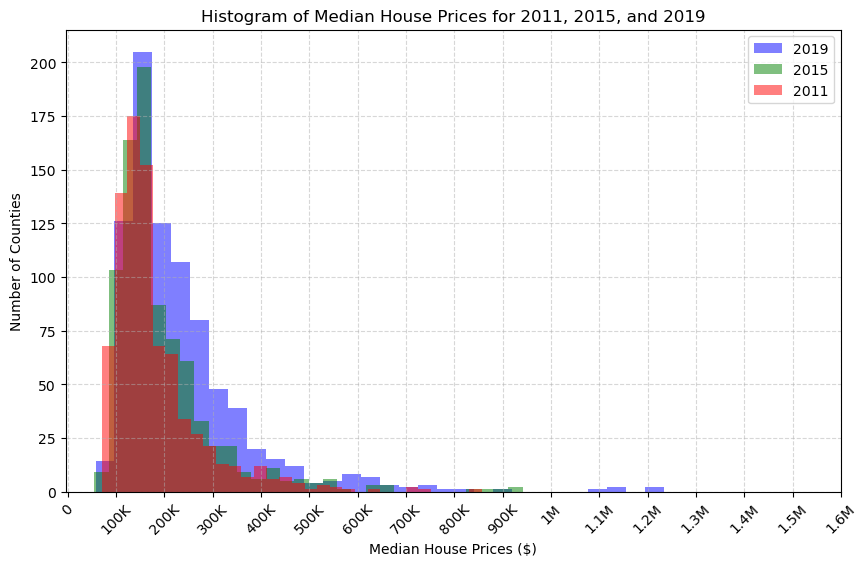

In [53]:
# Sample data for the years
data_2011 = clean_data_df.loc[clean_data_df['Year'] == 2011]["Median House Price ($)"]
data_2015 = clean_data_df.loc[clean_data_df['Year'] == 2015]["Median House Price ($)"]
data_2019 = clean_data_df.loc[clean_data_df['Year'] == 2019]["Median House Price ($)"]

# Plotting the histograms
plt.figure(figsize=(10, 6))
plt.hist(data_2019, bins=30, alpha=0.5, label='2019', color='blue')
plt.hist(data_2015, bins=30, alpha=0.5, label='2015', color='green')
plt.hist(data_2011, bins=30, alpha=0.5, label='2011', color='red')



# Adding titles and labels
plt.title('Histogram of Median House Prices for 2011, 2015, and 2019')
plt.xlabel('Median House Prices ($)')
plt.ylabel('Number of Counties')

# Define the ticks and labels
ticks = np.arange(0, 1700000, 100000)
labels = ['0', '100K', '200K', '300K', '400K', '500K', '600K', '700K', '800K', '900K', '1M', '1.1M', '1.2M', '1.3M', '1.4M', '1.5M', '1.6M']

# Set the ticks and labels
plt.xticks(ticks=ticks, labels=labels, rotation=45)

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right')

# Display the plot
plt.show()

In [8]:

region_df = clean_data_df[['County Name', 'Combined FIPS', 'Year', '% People Living in Poverty', 'Median House Price ($)']]

# Calculate Pearson correlation coefficient
correlation = region_df['% People Living in Poverty'].corr(region_df['Median House Price ($)'])
print(f'Pearson Correlation Coefficient between Poverty Rate and Housing Price: {correlation}')

# Create an interactive scatter plot with Plotly
fig = px.scatter(clean_data_df, x='% People Living in Poverty', y='Median House Price ($)', color='Year', 
                 hover_data=['County Name'], 
                 title='Poverty Rate vs. Median House Price by County')

fig.show()



Pearson Correlation Coefficient between Poverty Rate and Housing Price: -0.3939832375461344


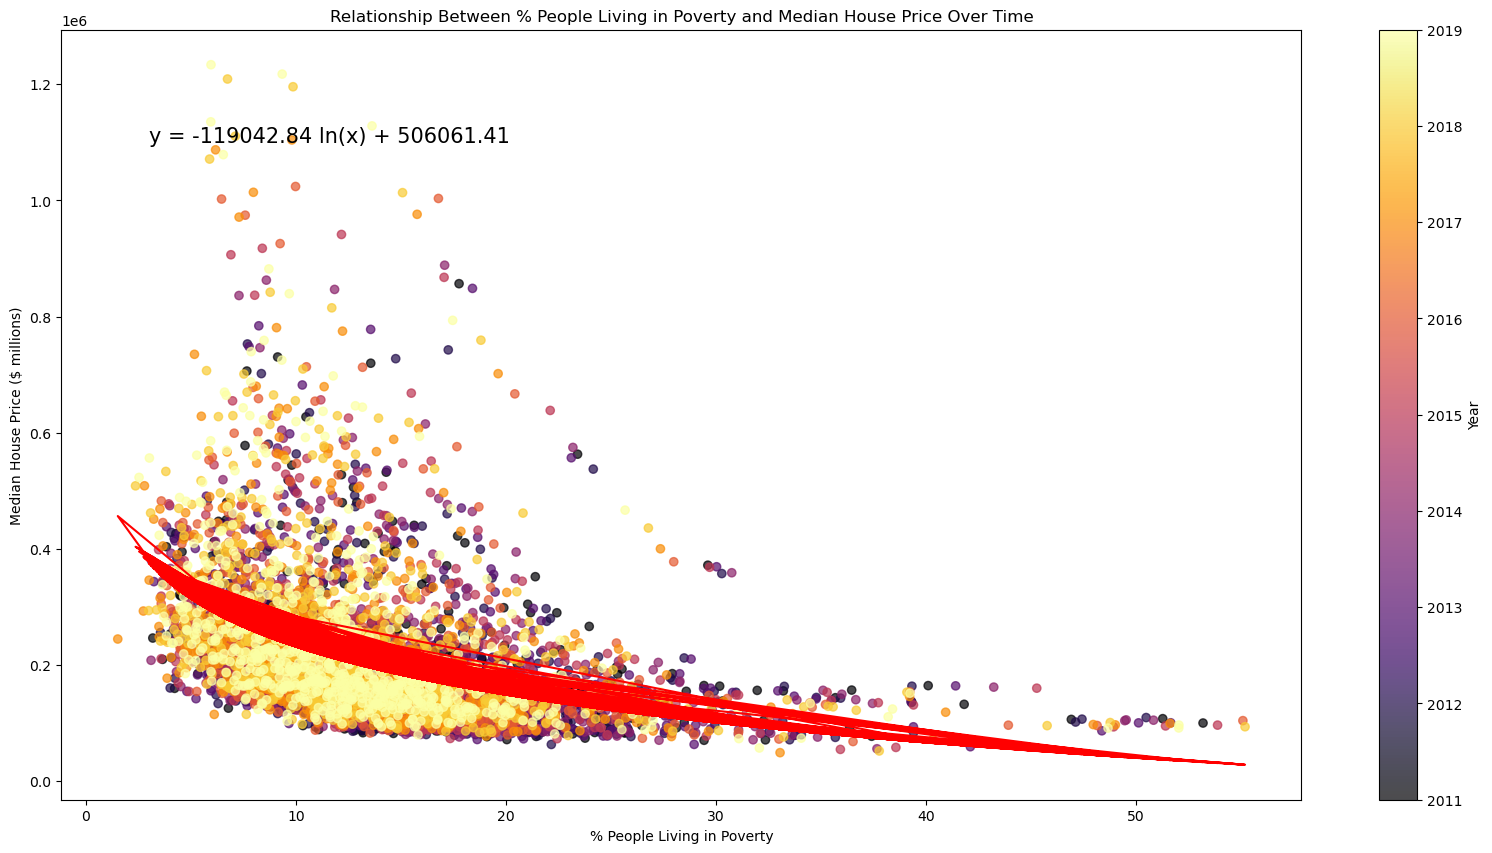

In [22]:

# Assuming clean_data_df is your DataFrame
X = clean_data_df['% People Living in Poverty']
Y = clean_data_df['Median House Price ($)']

# Transform the X variable using the natural logarithm
log_X = np.log(X)

# Perform linear regression on the transformed X variable
(slope, intercept, rvalue, pvalue, stderr) = linregress(log_X, Y)

# Calculate the regression values
regress_values = log_X * slope + intercept
line_eq = f"y = {slope:.2f} ln(x) + {intercept:.2f}"

# Scatter plot with color-coded years
plt.figure(figsize=(20, 10))
scatter = plt.scatter(X, Y, c=clean_data_df['Year'], cmap="inferno", alpha=0.7)
plt.colorbar(scatter, label='Year')
plt.title('Relationship Between % People Living in Poverty and Median House Price Over Time')
plt.xlabel('% People Living in Poverty')
plt.ylabel('Median House Price ($ millions)')

# Plot the logarithmic regression line
plt.plot(X, regress_values, "r-")
plt.annotate(line_eq, (3, 1100000), size=15)
plt.show()


A **correlation** of **-0.394** indicates a **moderate negative relationship**. This means that, generally:

As the **poverty rate increases**, the **housing prices tend to decrease**, or vice versa.
The correlation is not very strong, but it is noticeable enough to suggest a trend.

There is a **negative relationship** between the percentage of people living in poverty and the median house price. Specifically:

As the percentage of people living in poverty increases, the median house price is expected to decrease.
The slope of -7549.96 indicates that for each 1% increase in poverty, the median house price would decrease by about $7,549.96.
The intercept of 307839.66 suggests that in counties with no poverty, the median house price would be around $307,839.66.

In [ ]:
# Ensure data is loaded
file_path = 'census_data_all.csv'
census_data = pd.read_csv(file_path)
# Calculate Employment Rate if not already calculated
if '% People Living in Poverty' not in census_data.columns:
    census_data['% People Living in Poverty'] = (
        (census_data['People with Income Below Poverty'] / census_data['Total Population']) * 100
    )

In [42]:
temporal_data = census_data.groupby('Year').agg({
    'Median House Price ($)': 'mean',
    '% People Living in Poverty': 'mean',
}).reset_index()

In [43]:
temporal_data['Median House Price ($)'] = (
    (temporal_data['Median House Price ($)'] / temporal_data['Median House Price ($)'].iloc[0]) - 1) * 100
temporal_data['% People Living in Poverty'] = (
    (temporal_data['% People Living in Poverty'] / temporal_data['% People Living in Poverty'].iloc[0]) - 1) * 100


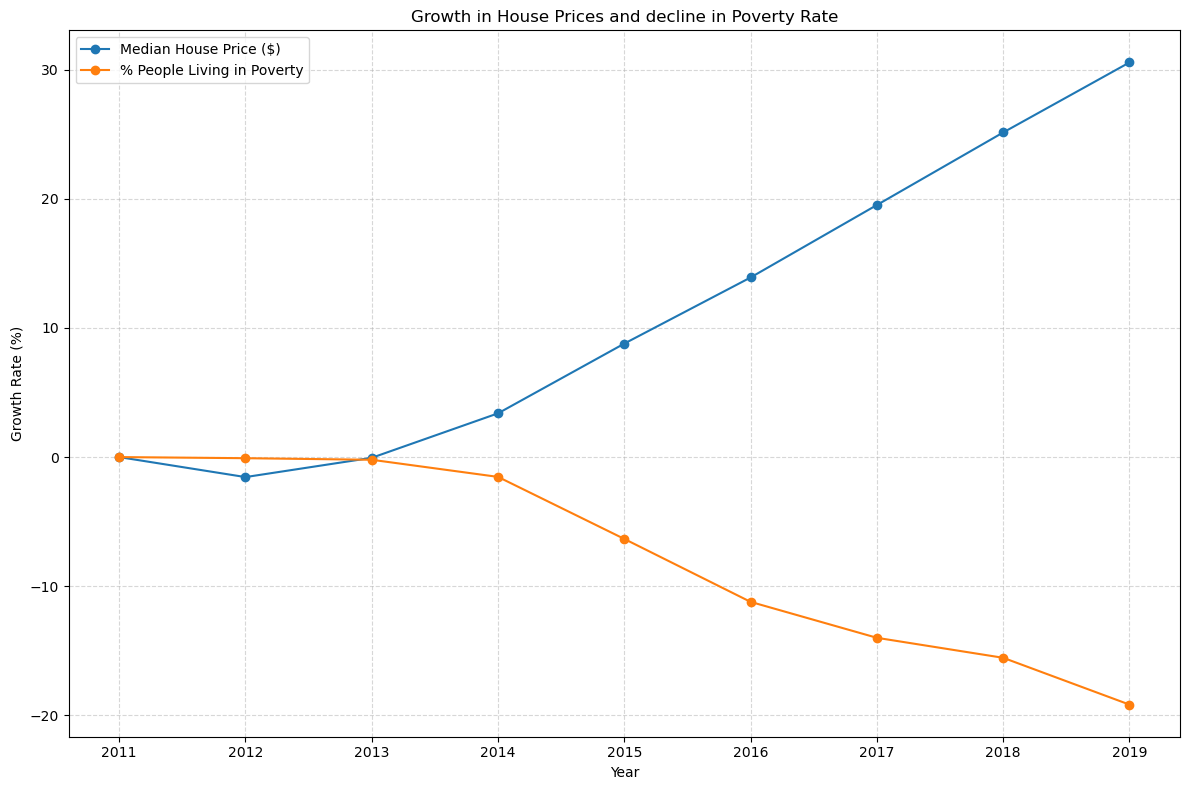

In [51]:
# Plot temporal trends
plt.figure(figsize=(12, 8))
plt.plot(temporal_data['Year'], temporal_data['Median House Price ($)'], label='Median House Price ($)', marker='o')
plt.plot(temporal_data['Year'], temporal_data['% People Living in Poverty'], label='% People Living in Poverty', marker='o')
#plt.plot(temporal_data['Year'], temporal_data['Employment Growth (%)'], label='Employment Growth (%)', marker='o')
plt.title('Growth in House Prices and decline in Poverty Rate')
plt.xlabel('Year')
plt.ylabel('Growth Rate (%)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
# Save the figure as an image file
plt.savefig("House_Pov_trends_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

C:\Users\bansr\AppData\Local\Temp\ipykernel_18164\1626160445.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



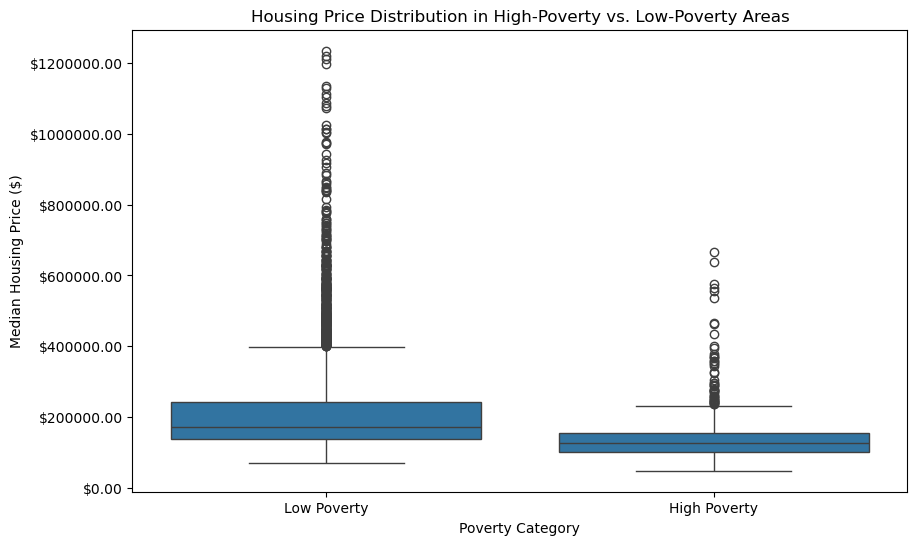

In [11]:
poverty_threshold = 20  
clean_data_df.loc[:, 'Poverty Category'] = np.where(clean_data_df['% People Living in Poverty'] > poverty_threshold, 'High Poverty', 'Low Poverty')

plt.figure(figsize=(10, 6))
sns.boxplot(x='Poverty Category', y='Median House Price ($)', data=clean_data_df)
plt.title('Housing Price Distribution in High-Poverty vs. Low-Poverty Areas')
plt.xlabel('Poverty Category')
plt.ylabel('Median Housing Price ($)')
plt.gca().yaxis.set_major_formatter(mtick.FormatStrFormatter('$%1.2f'))
plt.show()


Outliers indicates a small number of very expensive homes in some High Poverty areas. Whereas, it representing extremely expensive properties in Low Poverty areas.

In [12]:

# Group by year and calculate the mean poverty rate and median house price per year
yearly_data = clean_data_df.groupby('Year').agg({
    '% People Living in Poverty': 'mean',
    'Median House Price ($)': 'mean'
}).reset_index()




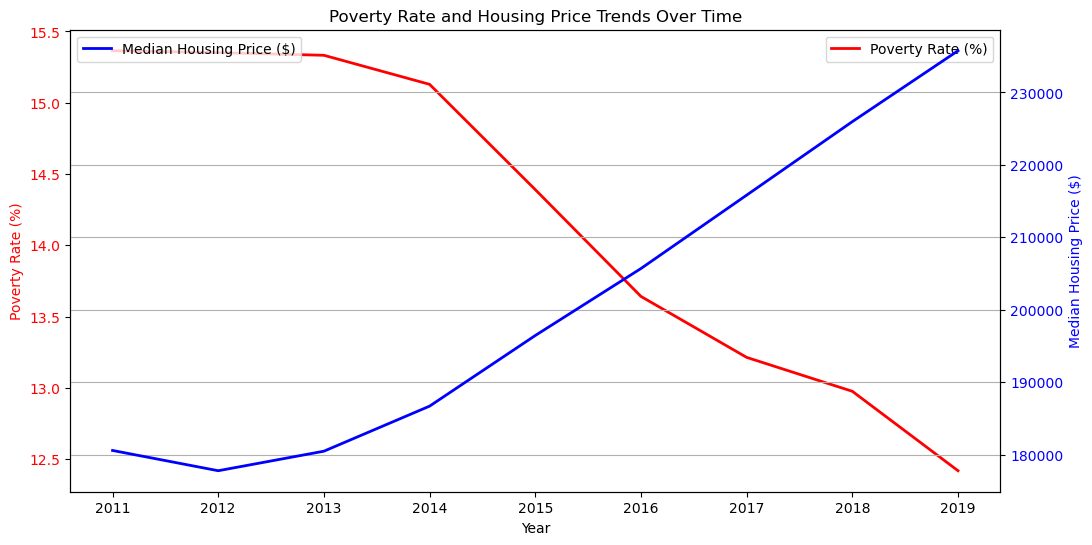

In [13]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot for Poverty Rate on the left Y-axis
ax1.set_xlabel('Year')
ax1.set_ylabel('Poverty Rate (%)', color='red')
sns.lineplot(x='Year', y='% People Living in Poverty', data=yearly_data, label='Poverty Rate (%)', color='red', linewidth=2, ax=ax1)
ax1.tick_params(axis='y', labelcolor='red')

# Create a second Y-axis for Median House Price
ax2 = ax1.twinx()  
ax2.set_ylabel('Median Housing Price ($)', color='blue')
sns.lineplot(x='Year', y='Median House Price ($)', data=yearly_data, label='Median Housing Price ($)', color='blue', linewidth=2, ax=ax2)
ax2.tick_params(axis='y', labelcolor='blue')

plt.title('Poverty Rate and Housing Price Trends Over Time')
plt.grid(True)
plt.show()


A **downward trend** indicates a reduction in poverty, while an **upward trend** indicate rising poverty rates. 
The graph shows how poverty levels have fluctuated over time.
It shows **Inverse Relationship** it suggests that as poverty levels improve, housing prices may be rising due to economic growth or investment in real estate.

C:\Users\bansr\AppData\Local\Temp\ipykernel_18164\726844251.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: xlabel='% People Living in Poverty', ylabel='Median House Price ($)'>

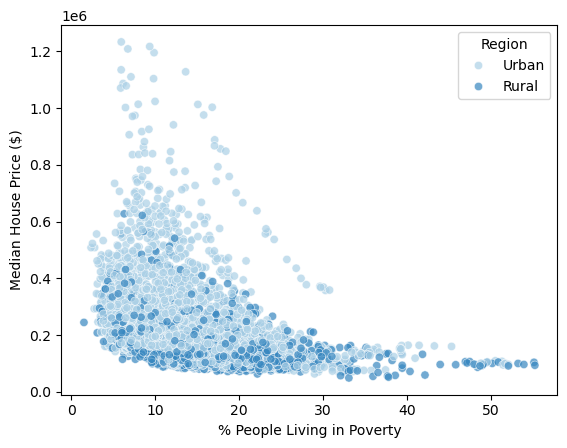

In [14]:
# Regions Classification as Urban or Rural based on population
clean_data_df.loc[:, 'Region'] = np.where(clean_data_df['Total Population'] >= 100000, 'Urban', 'Rural')


urban_df = clean_data_df[clean_data_df['Region'] == 'Urban']
rural_df = clean_data_df[clean_data_df['Region'] == 'Rural']

# data for regression
X = clean_data_df[['% People Living in Poverty']]  
X = sm.add_constant(X)    
y = clean_data_df['Median House Price ($)']  

#print(clean_data_df['Region'].value_counts())

sns.scatterplot(x='% People Living in Poverty', y='Median House Price ($)', hue='Region', data=clean_data_df, palette='Blues',alpha=0.7)



In [15]:
# Creating 'Region' column based on 'Total Population'
clean_data_df.loc[:, 'Region'] = np.where(clean_data_df['Total Population'] >= 100000, 'Urban', 'Rural')

urban_df = clean_data_df[clean_data_df['Region'] == 'Urban']
rural_df = clean_data_df[clean_data_df['Region'] == 'Rural']

# Calculate summary statistics
urban_summary = urban_df[['Median House Price ($)', '% People Living in Poverty']].describe()
rural_summary = rural_df[['Median House Price ($)', '% People Living in Poverty']].describe()



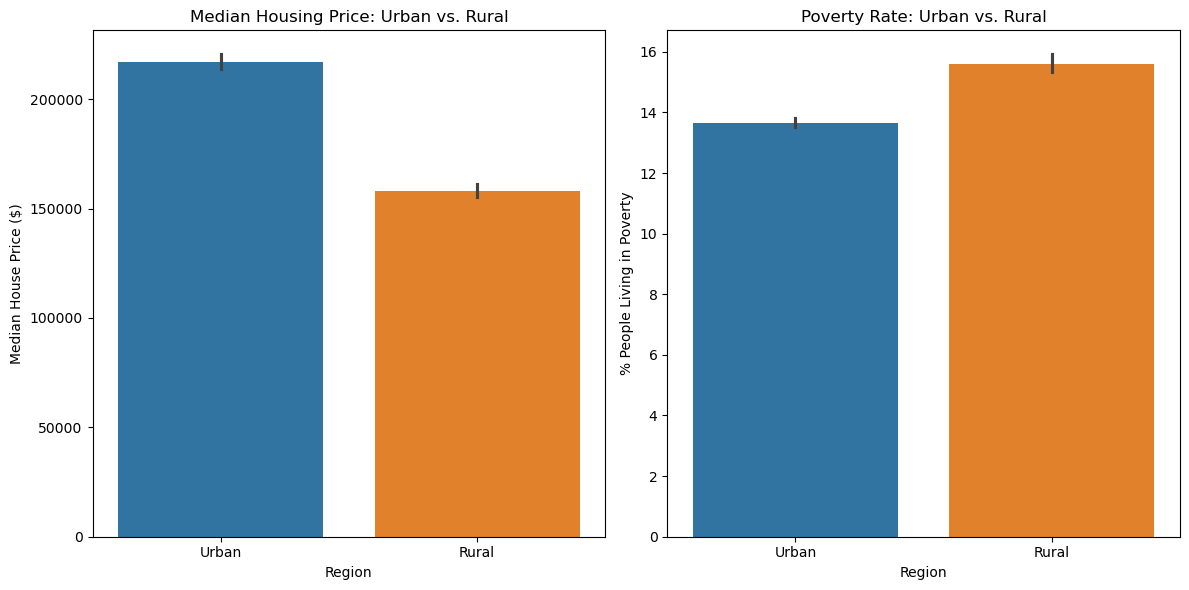

In [16]:
# Bar plot comparing Housing Price and Poverty Rate between Urban and Rural areas
plt.figure(figsize=(12, 6))

# Plot Housing Price comparison
plt.subplot(1, 2, 1)
sns.barplot(x="Region", 
            y="Median House Price ($)", 
            hue="Region",  
            data=clean_data_df)
plt.title("Median Housing Price: Urban vs. Rural")

# Plot Poverty Rate comparison
plt.subplot(1, 2, 2)
sns.barplot(x="Region", 
            y="% People Living in Poverty", 
            hue="Region", 
            data=clean_data_df)
plt.title("Poverty Rate: Urban vs. Rural")

plt.tight_layout()
plt.show()


Urban house prices indicates that urban markets are more dynamic and have more variation, with some cities seeing extremely high house prices.

Poverty rates are higher in rural areas, showing a contrast in the living conditions between urban and rural areas.

The graph clearly shows that **urban areas** have **higher housing prices** but **lower poverty rates** compared to **rural areas**, where **housing prices** are lower and **poverty rates** are higher.


In [17]:
clean_data_df

,County Name,Median House Price ($),Median Rent ($),Population with Bachelor's Degree,Total Population,Number of Employed People,People with Income Below Poverty,Total Labor Force,Median Household Income ($),Owner Occupied Housing Units,Total Households,State FIPS,County FIPS,Year,Annual Rent-to-Price Ratio,Employment Rate %,% People Living in Poverty,Combined FIPS,Poverty Category,Region
0,"Baldwin County, Alabama",170300,679,24157.0,186717,85257,24221.0,93619,50900,20213,74460,01,003,2011,4.784498,91.068052,12.972038,00301,Low Poverty,Urban
1,"Calhoun County, Alabama",99100,416,7750.0,117797,47363,24341.0,54373,39037,14023,44722,01,015,2011,5.037336,87.107572,20.663514,01501,High Poverty,Urban
2,"Cullman County, Alabama",112000,410,4878.0,80536,32689,14740.0,36250,40054,8012,31954,01,043,2011,4.392857,90.176552,18.302374,04301,Low Poverty,Rural
3,"DeKalb County, Alabama",97100,361,2465.0,71375,29227,13193.0,33281,36541,5242,27139,01,049,2011,4.461380,87.818876,18.484063,04901,Low Poverty,Rural
4,"Elmore County, Alabama",148900,479,8339.0,80162,33862,9749.0,38020,57405,5949,28469,01,051,2011,3.860309,89.063651,12.161623,05101,Low Poverty,Rural
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7474,"Toa Baja Municipio, Puerto Rico",111100,478,10751.0,74271,27886,28367.0,31768,23368,7574,28291,72,137,2019,5.162916,87.780156,38.193911,13772,High Poverty,Rural
7475,"Caguas Municipio, Puerto Rico",124500,463,20932.0,124606,47132,47851.0,52224,24507,16578,47669,72,025,2019,4.462651,90.249694,38.401843,02572,High Poverty,Urban
7476,"San Juan Municipio, Puerto Rico",151700,438,55716.0,318441,116362,124927.0,141555,23005,61677,138800,72,127,2019,3.464733,82.202677,39.230815,12772,High Poverty,Urban
7477,"Guaynabo Municipio, Puerto Rico",174700,532,18127.0,83728,35993,19101.0,39237,37499,10768,33125,72,061,2019,3.654264,91.732293,22.813157,06172,High Poverty,Rural
